# 連続データのFFT処理

時系列データのFFT処理を通じて、numpy,matplotlib,pandasの使い方を復習する。  
FFT処理の手順は下記の通りである  

1. DC成分の除去
2. ローパスフィルタ処理
3. 窓関数
4. FFT

## 準備

1. matplotlibのバックエンドをinlineに設定
2. matplotlib.pyplotのインポート
3. numpyのインポート
4. scipyからsignalモジュールをインポート
5. pandasのインポート

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import pandas as pd

## DC成分の除去
sensor_data.csvをpandasのDataFrameとして読み込む  
データ概要(describe)を確認する

In [2]:
df = pd.read_csv("./sensor_data.csv")
df.describe()

,time(s),channel_0
count,5001.000000,5001.000000
mean,2.500000,1.540173
std,1.443809,0.704321
min,0.000000,0.009412
25%,1.250000,1.095080
50%,2.500000,1.467272
75%,3.750000,1.894821
max,5.000000,3.455246


channel_0の平均値が0となるようにデータを加工する  
加工結果をグラフ化する

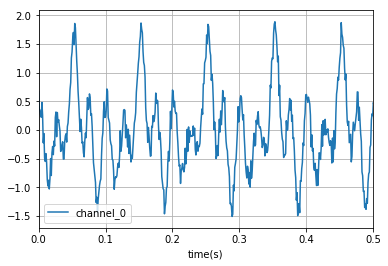

In [3]:
df.channel_0 -= df.channel_0.mean()
df.plot(x=df.columns[0],xlim=(0,0.5),grid=True)

## ローパスフィルタの設計
サンプリング間隔dtを抽出し、ナイキスト周波数$f_n$,カットオフ周波数$f_c$を決定する。
ただし、fn,fcは下記の通りとする

$$
\begin{align*}
f_n & = \frac{1.0}{2 \cdot dt} \\
f_c & = 0.2 * f_n
\end{align*}
$$

In [4]:
t = df.iloc[:,0]
dt = t[1]
fn = 1./(2*dt)
fc = 0.2 * fn
dt,fn,fc

(0.001, 500.0, 100.0)

今回カットオフ周波数の-10\[Hz\]を通過周波数$f_{pass}$、+100\[Hz\]を遮断周波数$f_{stop}$とする

In [5]:
fpass = fc - 10
fstop = fc + 100

下記の通りナイキスト周波数で無次元化した通過周波数$W_{pass}$、遮断周波数$w_{stop}$を定義する  
合わせて、帯域内（$f_{pass}$から$f_c$）の減衰量$R_{pass}$\[dB\]及び、減衰域（$f_c$ から$f_{stop}$）の減衰量$R_{stop}$\[dB\]は下記の通り定義する

$$
\begin{align*}
W_{pass} & = \frac{f_{pass}}{f_n} \\
W_{stop} & = \frac{f_{stop}}{f_n} \\
R_{pass} & = 1 \quad[dB]\\
R_{stop} & = 30 \quad[dB]
\end{align*}
$$

In [6]:
Wpass = fpass / fn
Wstop = fstop / fn
Rpass = 1
Rstop = 30

signale.buttordを用いて、無次元化カットオフ周波数$W_n$及び、必要なフィルタ最低次数$N$を計算する  
```python
N, Wn = signal.buttord(Wpass, Wstop, Rpass, Rstop)
```

次に、ローパスのIIRフィルタを表す多項式の分子b,分母aを計算する  
```python
b, a = signal.butter(N, Wn, "low")
```

さらにa,bであらわされるフィルタをchannel_0のデータに適用する
```python
y_low = signal.filtfilt(b, a, df[df.columns[1]])
```


In [7]:
N, Wn = signal.buttord(Wpass, Wstop, Rpass, Rstop)
b, a = signal.butter(N, Wn, "low")
y_low = signal.filtfilt(b, a, df[df.columns[1]])
N,Wn

(5, 0.20438905064150437)

元のデータ及びローパスをかけた後のデータを重ねてプロットする

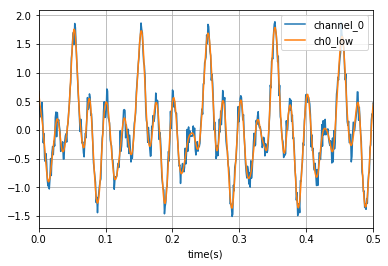

In [8]:
df.plot(x=df.columns[0],xlim=(0,0.5),grid=True)
plt.plot(df[df.columns[0]], y_low,label="ch0_low")
plt.legend()

尚、適用したフィルタの特性はアナログフィルタとして確認する

```python
b_ana, a_ana = signal.butter(N, Wn, "low", analog=True)
w, h = signal.freqs(b_ana, a_ana)
plt.plot(w, 20*np.log10(abs(h)))
```

b_ana,a_anaはアナログフィルタとしての定数である。また、wは無次元周波数である。
合わせて、カットオフ周波数(無次元)の表示する  
あるxの値に縦線を引きたい場合、下記のようにする。
```python
plt.axvline(Wn, color='green',label="cutoff freq")
```

WstopやWpassもプロットし、フィルタが設計通りの特性になっていることを確認する

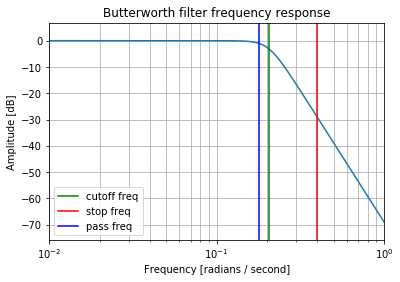

In [9]:
b_ana, a_ana = signal.butter(N, Wn, "low", analog=True)
w, h = signal.freqs(b_ana, a_ana)
plt.plot(w, 20*np.log10(abs(h)))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(Wn, color='green',label="cutoff freq") # cutoff frequency
plt.axvline(Wstop, color='red',label="stop freq")
plt.axvline(Wpass, color='blue',label="pass freq")
plt.legend()

## 窓関数
```np.hamming(size)```を用いることで容易にハミング窓が作成できる。  
これをローパスフィルタ適用済みのy_lowと掛け合わせる

In [10]:
hammingWindow = np.hamming(y_low.size)
y_win = hammingWindow * y_low

プロットすることで、初期時間と最終時間の振幅が小さくなっていることがわかる

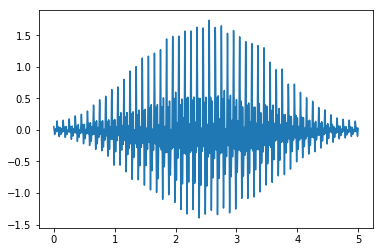

In [11]:
plt.plot(t,y_win)

## FFT処理

下記のようにfftfreqメソッドを用いれば、周波数配列を作成できる。
ただし、データは前半分でよい（後ろ半分は不要）  

```python
np.fft.fftfreq(y_win.size,dt)
```

さらにfftメソッドを用いればFFTできる    
こちらもデータは前半分でよい
```python
np.fft.fft(y_data)
```

元データ、ローパスフィルタをかけた後のデータ、窓関数も適用したデータの３データ分FFTする

In [12]:
freq = np.fft.fftfreq(y_win.size,dt)[:int(y_win.size/2)]

y_fft_win = np.fft.fft(y_win)[:int(y_win.size/2)]
y_fft_low = np.fft.fft(y_low)[:int(y_win.size/2)]
y_fft_org = np.fft.fft(df.channel_0)[:int(y_win.size/2)]

元データ、ローパスフィルタをかけた後のデータ、窓関数も適用したデータのFFTの振幅をプロットする。  
ローパスフィルタにて90\[Hz\]付近から減衰していることがわかる。   
また、窓関数の減衰の影響も確認できる  

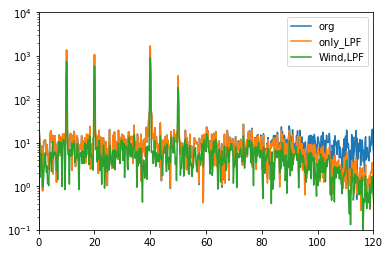

In [13]:
plt.plot(freq,np.abs(y_fft_org), label="org")
plt.plot(freq,np.abs(y_fft_low),label="only_LPF")
plt.plot(freq,np.abs(y_fft_win),label="Wind,LPF")
plt.xlim(0,120)
plt.ylim(1e-1,10000)
plt.yscale("log")
plt.legend()

## おまけ
上凸のピーク値検出には、signal.argrelmaxが便利である
該当のindexを取得できる。
```python
maxp = signal.argrelmax(np.abs(y_fft_win),order=30)
```

In [14]:
maxp = signal.argrelmax(np.abs(y_fft_win),order=30)
freq[maxp],np.abs(y_fft_win[maxp])

(array([1.99960008e-01, 9.99800040e+00, 1.99960008e+01, 3.99920016e+01,
        4.99900020e+01, 6.01879624e+01, 7.33853229e+01, 8.97820436e+01,
        1.10377924e+02, 1.29374125e+02, 1.38172366e+02, 2.01959608e+02]),
 array([1.26908912e+01, 7.35373104e+02, 5.78735153e+02, 9.06434577e+02,
        1.86750136e+02, 1.59592979e+01, 1.43242520e+01, 1.12350087e+01,
        4.01879483e+00, 9.68919531e-01, 5.10116190e-01, 3.46152157e-02]))

```np.abs(y_fft_win)```のplot以外に、```plt.scatter(freq[maxp],np.abs(y_fft_win[maxp]))```を行うといい感じに表示される

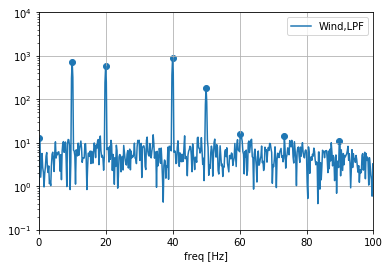

In [15]:
plt.plot(freq,np.abs(y_fft_win),label="Wind,LPF")
plt.scatter(freq[maxp],np.abs(y_fft_win[maxp]))
plt.xlim(0,100)
plt.ylim(1e-1,10000)
plt.xlabel("freq [Hz]")
plt.yscale("log")
plt.legend()
plt.grid(True)

## 参考文書

[実践に即したデジタル フィルター設計の紹介](https://jp.mathworks.com/help/signal/examples/practical-introduction-to-digital-filter-design.html) MathWorks


---
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img align="right" alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><br />
<div align="right"><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">python4engineer</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="https://github.com/TatsuyaKatayama/python4engineer" property="cc:attributionName" rel="cc:attributionURL">TatsuyaKatayama</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. </div>
